In [1]:
!pip install -U efficientnet &> /dev/null
!pip install -U albumentations &> /dev/null

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'1.+TABLE+OF+CONTENTS+(Thesis)+-+SAMPLE+1.docx'   Models
'2.+TABLE+OF+CONTENT+(Thesis)+-+SAMPLE+2.docx'	 'My Drive'
'Colab Notebooks'				  NKFoodie.zip
 CXP_EfficientNetB3.h5				  NK_Interim_Report.docx
 Final_Thesis_Sample.pdf			  Public
 images						  yolov3
 LPM						  yolov4


In [4]:
!cp /mydrive/Public/RSNA_Pneumonia_0M_100F.zip /content/

In [5]:
!unzip /content/RSNA_Pneumonia_0M_100F -d /content/ &> /dev/null

In [6]:
# Dataset paths and classes
parent="RSNA_Pneumonia_0M_100F"
train_path = parent+"/Train"
val_path=parent+"/Val"
test_path =parent+"/Test"

In [7]:
#Helper
import random
import numpy as np
import pandas as pd
import os

# Modeling
import tensorflow as tf
import efficientnet.keras as efn 
from keras import Model
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,GlobalAveragePooling2D,GlobalMaxPooling2D,Flatten,Conv2D, MaxPooling2D,Activation,Input
from keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

#Image Processing
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import albumentations as A
from PIL import Image
import keras_preprocessing

#Metrics
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,f1_score
from sklearn import metrics

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

#Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
#Constants
IMG_SIZE=300
batch_size=16

#Training
lr=1e-5
epochs=70
decay_rate=0.5
patience=5

In [9]:
def print_classification_report(y_true,y_pred):
    cf_matrix=confusion_matrix(np.array(y_true), np.array(y_pred))
    sns.heatmap(cf_matrix, annot=True,cmap='Blues',fmt='g')
    print('Classification Report')
    target_names = ['Not Pneumonia', 'Pneumonia']
    print(classification_report(np.array(y_true), y_pred, target_names=target_names,))

In [10]:
def plot_roc(y_true,y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y_true),np.array(y_pred))
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [12]:
def preprocess_xray(img):
    xray=img.astype('uint8')
    transform = A.Compose(A.OneOf([A.CLAHE(clip_limit=4)
                                  ,A.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=cv2.BORDER_REPLICATE)
                                  ]),p=0.5)
    augmented_image = transform(image=xray)['image']
    return augmented_image.astype('float32')

In [13]:
def show_xray(xray_path):
    if isinstance(xray_path, str):
        xray=cv2.imread(xray_path)
        plt.imshow(xray)
    else:
        plt.imshow(xray_path)

In [14]:
!nvidia-smi

Fri May  7 12:54:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
#Get the train data
train_datagen= ImageDataGenerator(rescale=1./255.
                                 ,horizontal_flip=True
                                 ,rotation_range=5   
                                 ,brightness_range=[0.8,1.0]
                                 ,shear_range=0.2
                                 #,zoom_range=0.3
                                 ,preprocessing_function=preprocess_xray
                                )
                                 
train_generator=train_datagen.flow_from_directory(
            directory=train_path,
            target_size=(IMG_SIZE,IMG_SIZE),
            batch_size=batch_size,
            shuffle=True
            )

Found 4000 images belonging to 2 classes.


In [16]:
train_generator.class_indices

{'Not Pneumonia': 0, 'Pneumonia': 1}

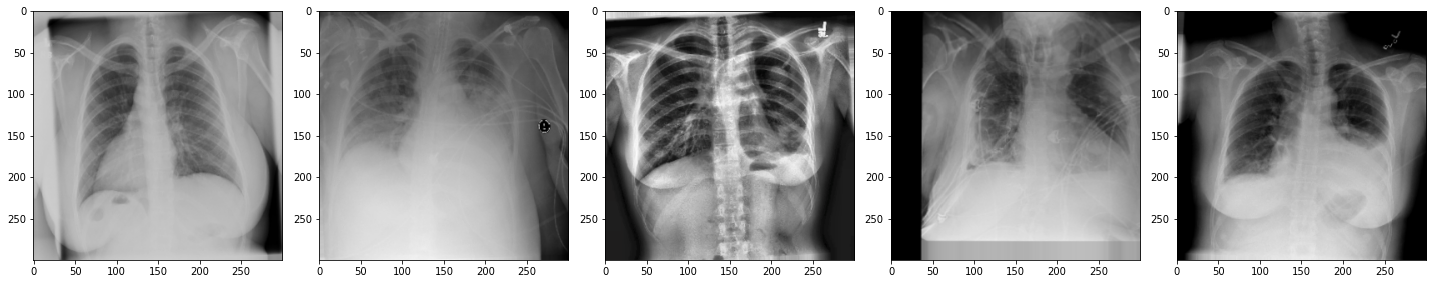

In [17]:
augmented_images = [train_generator[0][0][i] for i in range(5)]
plotImages(augmented_images)

In [18]:
val_datagen= ImageDataGenerator(rescale=1./255.)
validation_generator = val_datagen.flow_from_directory(
                        directory=val_path, 
                        target_size=(IMG_SIZE,IMG_SIZE),
                        batch_size=batch_size,
                        shuffle=False
                        )

Found 600 images belonging to 2 classes.


In [19]:
validation_generator.class_indices

{'Not Pneumonia': 0, 'Pneumonia': 1}

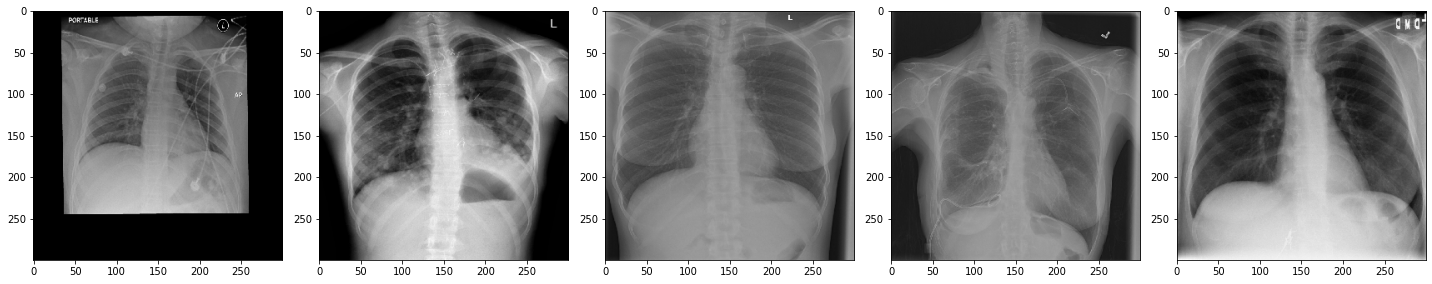

In [20]:
augmented_images = [validation_generator[0][0][i] for i in range(5)]
plotImages(augmented_images)

In [21]:
efficientNet = efn.EfficientNetB3(include_top=False,weights='noisy-student',input_shape=(IMG_SIZE,IMG_SIZE,3))

x = efficientNet.output
x = GlobalAveragePooling2D(name='cxr_GlobalAvgPooling')(x)
x = BatchNormalization(name='cxr_BatchNormalization')(x)
x = Dropout(0.4,name="cxr_dropout_1")(x)
x = Dense(units=512,activation='relu',name='cxr_dense512')(x)
x = Dense(units=128,activation='relu',name='cxr_dense128')(x)
x = Dense(units=64,activation='relu',name='cxr_dense64')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax',name='cxr_softmax')(x)
model = Model(inputs=efficientNet.input, outputs=predictions)

model.summary()

43933696/43933088 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
_____________________________

In [22]:
optim=Adam(learning_rate=lr)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
checkpoint_filepath = 'Model/'+parent+'_.Epoch{epoch:02d}-Val_Acc{val_accuracy:.3f}_Val_Loss{val_loss:.3f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_filepath,
                            save_weights_only=False,
                            save_freq='epoch',
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True
                            )

rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = patience, factor = decay_rate, verbose = 1,cooldown=1)
estop = EarlyStopping(monitor="val_loss",patience=8,verbose=1,mode="auto")

In [24]:
history = model.fit(
            train_generator,
            epochs = epochs,
            validation_data = validation_generator,
            verbose = 1,
            callbacks = [model_checkpoint_callback,rlrop]
            )

Epoch 1/70
250/250 [==============================] - 154s 509ms/step - loss: 0.7435 - accuracy: 0.5609 - val_loss: 0.6731 - val_accuracy: 0.5833
Epoch 2/70
250/250 [==============================] - 126s 503ms/step - loss: 0.6395 - accuracy: 0.6627 - val_loss: 0.6428 - val_accuracy: 0.6367
Epoch 3/70
250/250 [==============================] - 125s 499ms/step - loss: 0.6071 - accuracy: 0.7019 - val_loss: 0.6071 - val_accuracy: 0.6700
Epoch 4/70
250/250 [==============================] - 126s 503ms/step - loss: 0.5944 - accuracy: 0.7074 - val_loss: 0.5847 - val_accuracy: 0.7300
Epoch 5/70
250/250 [==============================] - 125s 499ms/step - loss: 0.5696 - accuracy: 0.7222 - val_loss: 0.5981 - val_accuracy: 0.7233
Epoch 6/70
250/250 [==============================] - 125s 500ms/step - loss: 0.5627 - accuracy: 0.7230 - val_loss: 0.5826 - val_accuracy: 0.7283
Epoch 7/70
250/250 [==============================] - 126s 502ms/step - loss: 0.5374 - accuracy: 0.7392 - val_loss: 0.5794 -

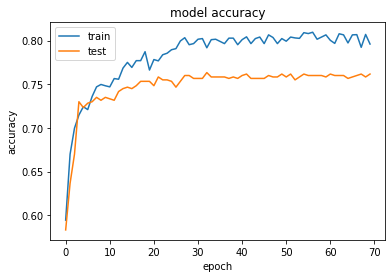

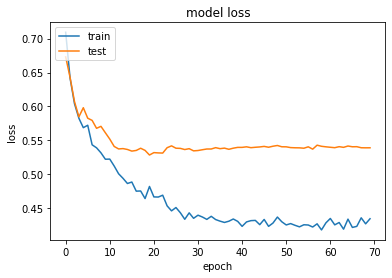

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [26]:
model.save(parent+".h5")

In [27]:
test_model=tf.keras.models.load_model(parent+".h5")
#test_model=tf.keras.models.load_model('/content/Model/RSNA_Pneumonia_0M_100F_.Epoch29-Val_Acc0.767_Val_Loss0.518.h5')

In [28]:
!cp /mydrive/Public/Subsets.zip /content/

In [29]:
!unzip /content/Subsets -d /content/ &> /dev/null

In [30]:
test_dir_path=[test_path+"/Pneumonia",test_path+"/Not Pneumonia"]

In [31]:
rsna_df=pd.read_csv("Subsets/"+parent+".csv")

In [32]:
rsna_df['label_description']=rsna_df['label'].map({0:'Not Pneumonia',1:'Pneumonia'})

In [33]:
data=[]
for directory in test_dir_path:
    for file in os.listdir(directory):
        data.append(file.replace(".png",".dcm"))

In [34]:
rsna_test_df=rsna_df[rsna_df['dicom'].isin(data)]

In [35]:
rsna_test_df['xray_file']=test_path+"/"+rsna_test_df['label_description']+"/"+rsna_test_df['xray']
rsna_test_df['label_description'].value_counts()

Not Pneumonia    300
Pneumonia        300
Name: label_description, dtype: int64

In [36]:
test_gen=ImageDataGenerator(rescale=1./255.)
test_generator=test_gen.flow_from_dataframe(rsna_test_df
                                           ,x_col='xray_file'
                                           ,y_col='label'
                                           ,target_size=(IMG_SIZE,IMG_SIZE) 
                                           ,class_mode=None
                                           ,shuffle=False
                                           )

Found 600 validated image filenames.


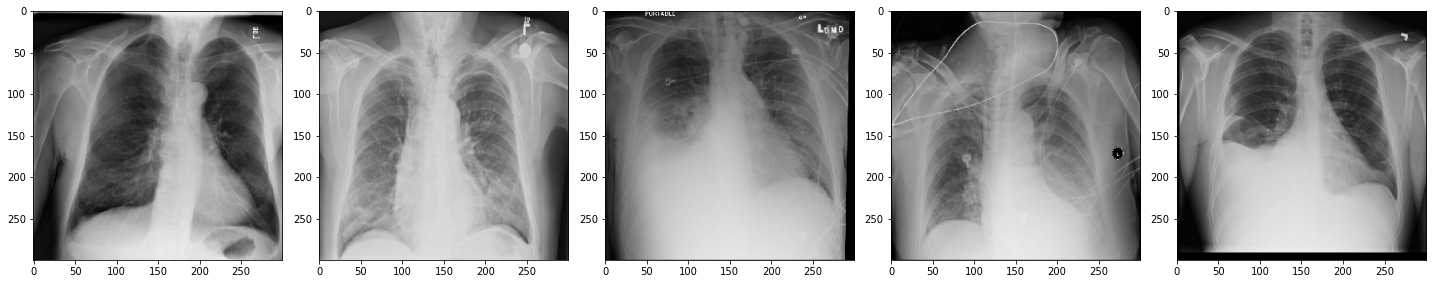

In [37]:
augmented_images = [test_generator[0][i] for i in range(5)]
plotImages(augmented_images)

In [38]:
%%time
y_pred = test_model.predict(test_generator)

CPU times: user 8.99 s, sys: 528 ms, total: 9.52 s
Wall time: 8.62 s


In [39]:
predictions = np.argmax(y_pred, axis=1)
prediction_probs=[class_prob[1] for class_prob in y_pred]
rsna_test_df['ENetB3']=predictions
rsna_test_df['ENetB3_probs']=prediction_probs
rsna_test_df['ENetB3_description']=rsna_test_df['ENetB3'].map({0:'Not Pneumonia',1:'Pneumonia'})

In [40]:
f1_score(rsna_test_df['label'].values,rsna_test_df['ENetB3'].values,average='micro')

0.7766666666666666

Classification Report
               precision    recall  f1-score   support

Not Pneumonia       0.79      0.76      0.77       300
    Pneumonia       0.77      0.79      0.78       300

     accuracy                           0.78       600
    macro avg       0.78      0.78      0.78       600
 weighted avg       0.78      0.78      0.78       600



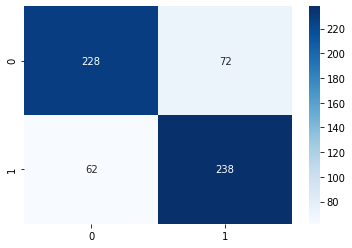

In [41]:
print_classification_report(rsna_test_df['label'].values,rsna_test_df['ENetB3'].values)

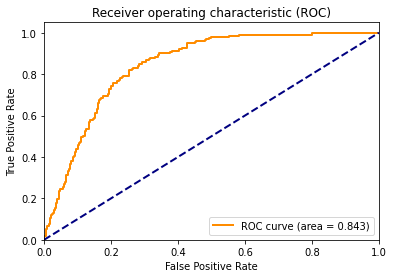

In [42]:
plot_roc(rsna_test_df['label'].values,rsna_test_df['ENetB3_probs'].values)

In [43]:
f1_score(rsna_test_df[rsna_test_df['sex']=='F']['label'].values,rsna_test_df[rsna_test_df['sex']=='F']['ENetB3'].values,average='micro')

0.79

Classification Report
               precision    recall  f1-score   support

Not Pneumonia       0.80      0.77      0.78       150
    Pneumonia       0.78      0.81      0.79       150

     accuracy                           0.79       300
    macro avg       0.79      0.79      0.79       300
 weighted avg       0.79      0.79      0.79       300



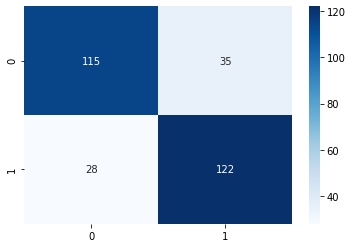

In [44]:
print_classification_report(rsna_test_df[rsna_test_df['sex']=='F']['label'].values,rsna_test_df[rsna_test_df['sex']=='F']['ENetB3'].values)

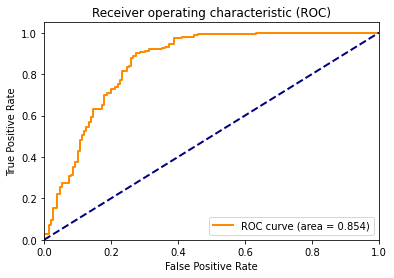

In [45]:
plot_roc(rsna_test_df[rsna_test_df['sex']=='F']['label'].values,rsna_test_df[rsna_test_df['sex']=='F']['ENetB3_probs'].values)

In [46]:
f1_score(rsna_test_df[rsna_test_df['sex']=='M']['label'].values,rsna_test_df[rsna_test_df['sex']=='M']['ENetB3'].values,average='micro')

0.7633333333333333

Classification Report
               precision    recall  f1-score   support

Not Pneumonia       0.77      0.75      0.76       150
    Pneumonia       0.76      0.77      0.77       150

     accuracy                           0.76       300
    macro avg       0.76      0.76      0.76       300
 weighted avg       0.76      0.76      0.76       300



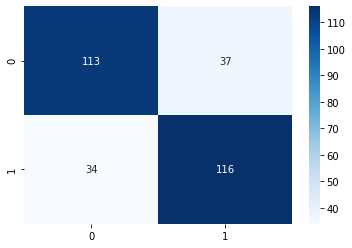

In [47]:
print_classification_report(rsna_test_df[rsna_test_df['sex']=='M']['label'].values,rsna_test_df[rsna_test_df['sex']=='M']['ENetB3'].values)

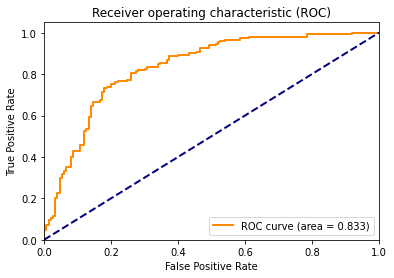

In [48]:
plot_roc(rsna_test_df[rsna_test_df['sex']=='M']['label'].values,rsna_test_df[rsna_test_df['sex']=='M']['ENetB3_probs'].values)

In [49]:
detailed_truth=pd.read_csv('Subsets/stage_2_detailed_class_info.csv')
detailed_truth.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [50]:
pathology="Not Pneumonia"
nofinding_errors=rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)]

In [51]:
def get_detailed_truth(df):
    return detailed_truth[detailed_truth['patientId']==df['patient_id']]['class'].values[0]

In [52]:
nofinding_errors['detailed_truth']=nofinding_errors.apply(get_detailed_truth,axis=1)
nofinding_errors[['label_description','detailed_truth','ENetB3_description']].groupby(['detailed_truth']).count()

,label_description,ENetB3_description
detailed_truth,,
No Lung Opacity / Not Normal,68,68
Normal,4,4


In [53]:
pathology="Pneumonia"
pneumonia_errors=rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)]

In [54]:
pneumonia_errors['detailed_truth']=pneumonia_errors.apply(get_detailed_truth,axis=1)
pneumonia_errors[['label_description','detailed_truth','ENetB3_description']].groupby(['detailed_truth']).count()

,label_description,ENetB3_description
detailed_truth,,
Lung Opacity,62,62


In [55]:
pathology="Not Pneumonia"
rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)][['xray','sex','label_description','ENetB3_description','ENetB3_probs']].head(5)

,xray,sex,label_description,ENetB3_description,ENetB3_probs
2198,d1cf6d7d-0e8f-4c94-8ce7-739388aed78a.png,M,Not Pneumonia,Pneumonia,0.675364
2201,e0fa42ad-0d4a-4827-bc8a-812825aab227.png,M,Not Pneumonia,Pneumonia,0.626209
2202,55e8ab4e-b6c3-4424-bae7-3b17849a1141.png,M,Not Pneumonia,Pneumonia,0.972803
2207,695b6d1e-f8d7-426a-8abe-aba77943ab71.png,M,Not Pneumonia,Pneumonia,0.978739
2210,11d8e718-ca03-4f4d-95fc-da6d9ba1434f.png,M,Not Pneumonia,Pneumonia,0.593760


In [56]:
pathology="Pneumonia"
rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)][['xray','sex','label_description','ENetB3_description','ENetB3_probs']].head(5)

,xray,sex,label_description,ENetB3_description,ENetB3_probs
4188,e21916f2-b79a-4a00-85e7-ad6a27c300c2.png,M,Pneumonia,Not Pneumonia,0.362818
4190,dc7720ba-e9fe-4680-8304-bb149bedf128.png,M,Pneumonia,Not Pneumonia,0.403409
4195,32764f2f-ea89-4d7c-aa7d-e70366218270.png,M,Pneumonia,Not Pneumonia,0.021665
4201,1614564a-fe0d-43dc-87ae-299d859959f6.png,M,Pneumonia,Not Pneumonia,0.021568
4208,3ba80992-3ec3-421a-97b8-354f1a5dbae1.png,M,Pneumonia,Not Pneumonia,0.390396


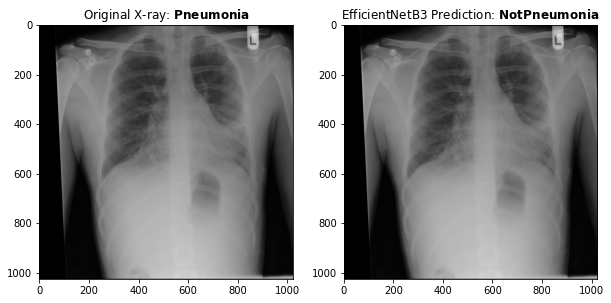

In [57]:
df_index=rsna_test_df[(rsna_test_df['label_description']==pathology)
            &(rsna_test_df['ENetB3_description']!=pathology)].index[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
show_xray(rsna_test_df.loc[df_index]['xray_file'])
plt.title("Original X-ray: "+ r"$\bf{Pneumonia"+ "}$");
plt.subplot(1,2,2)
show_xray(rsna_test_df.loc[df_index]['xray_file'])
plt.title("EfficientNetB3 Prediction: "+ r"$\bf{Not Pneumonia"+ "}$");

In [58]:
!cp "/content/RSNA_Pneumonia_0M_100F.h5" /mydrive/Public/